In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# import data
df = pd.read_csv('train.csv')
te_df = pd.read_csv('test.csv')
# df.head(3)

Data Visualization

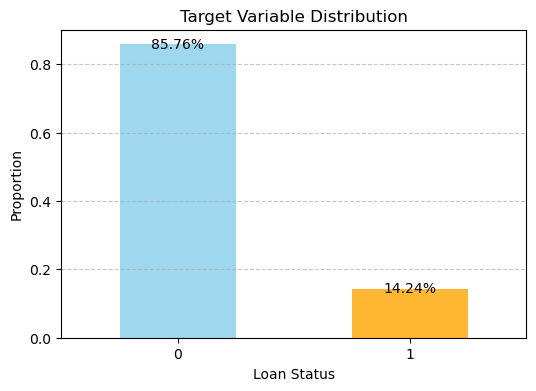

In [3]:
# 檢查資料平衡性
target = 'loan_status'

target_proportions = df[target].value_counts(normalize=True)

# 繪製目標變數的分佈圖
plt.figure(figsize=(6, 4))
bars = target_proportions.plot(kind='bar', color=['skyblue', 'orange'], alpha=0.8)

# 標註比例
for bar in bars.patches:
    proportion = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, proportion - 0.02, 
             f'{proportion:.2%}', ha='center', va='bottom', fontsize=10, color='black')

plt.title('Target Variable Distribution')
plt.xlabel('Loan Status')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

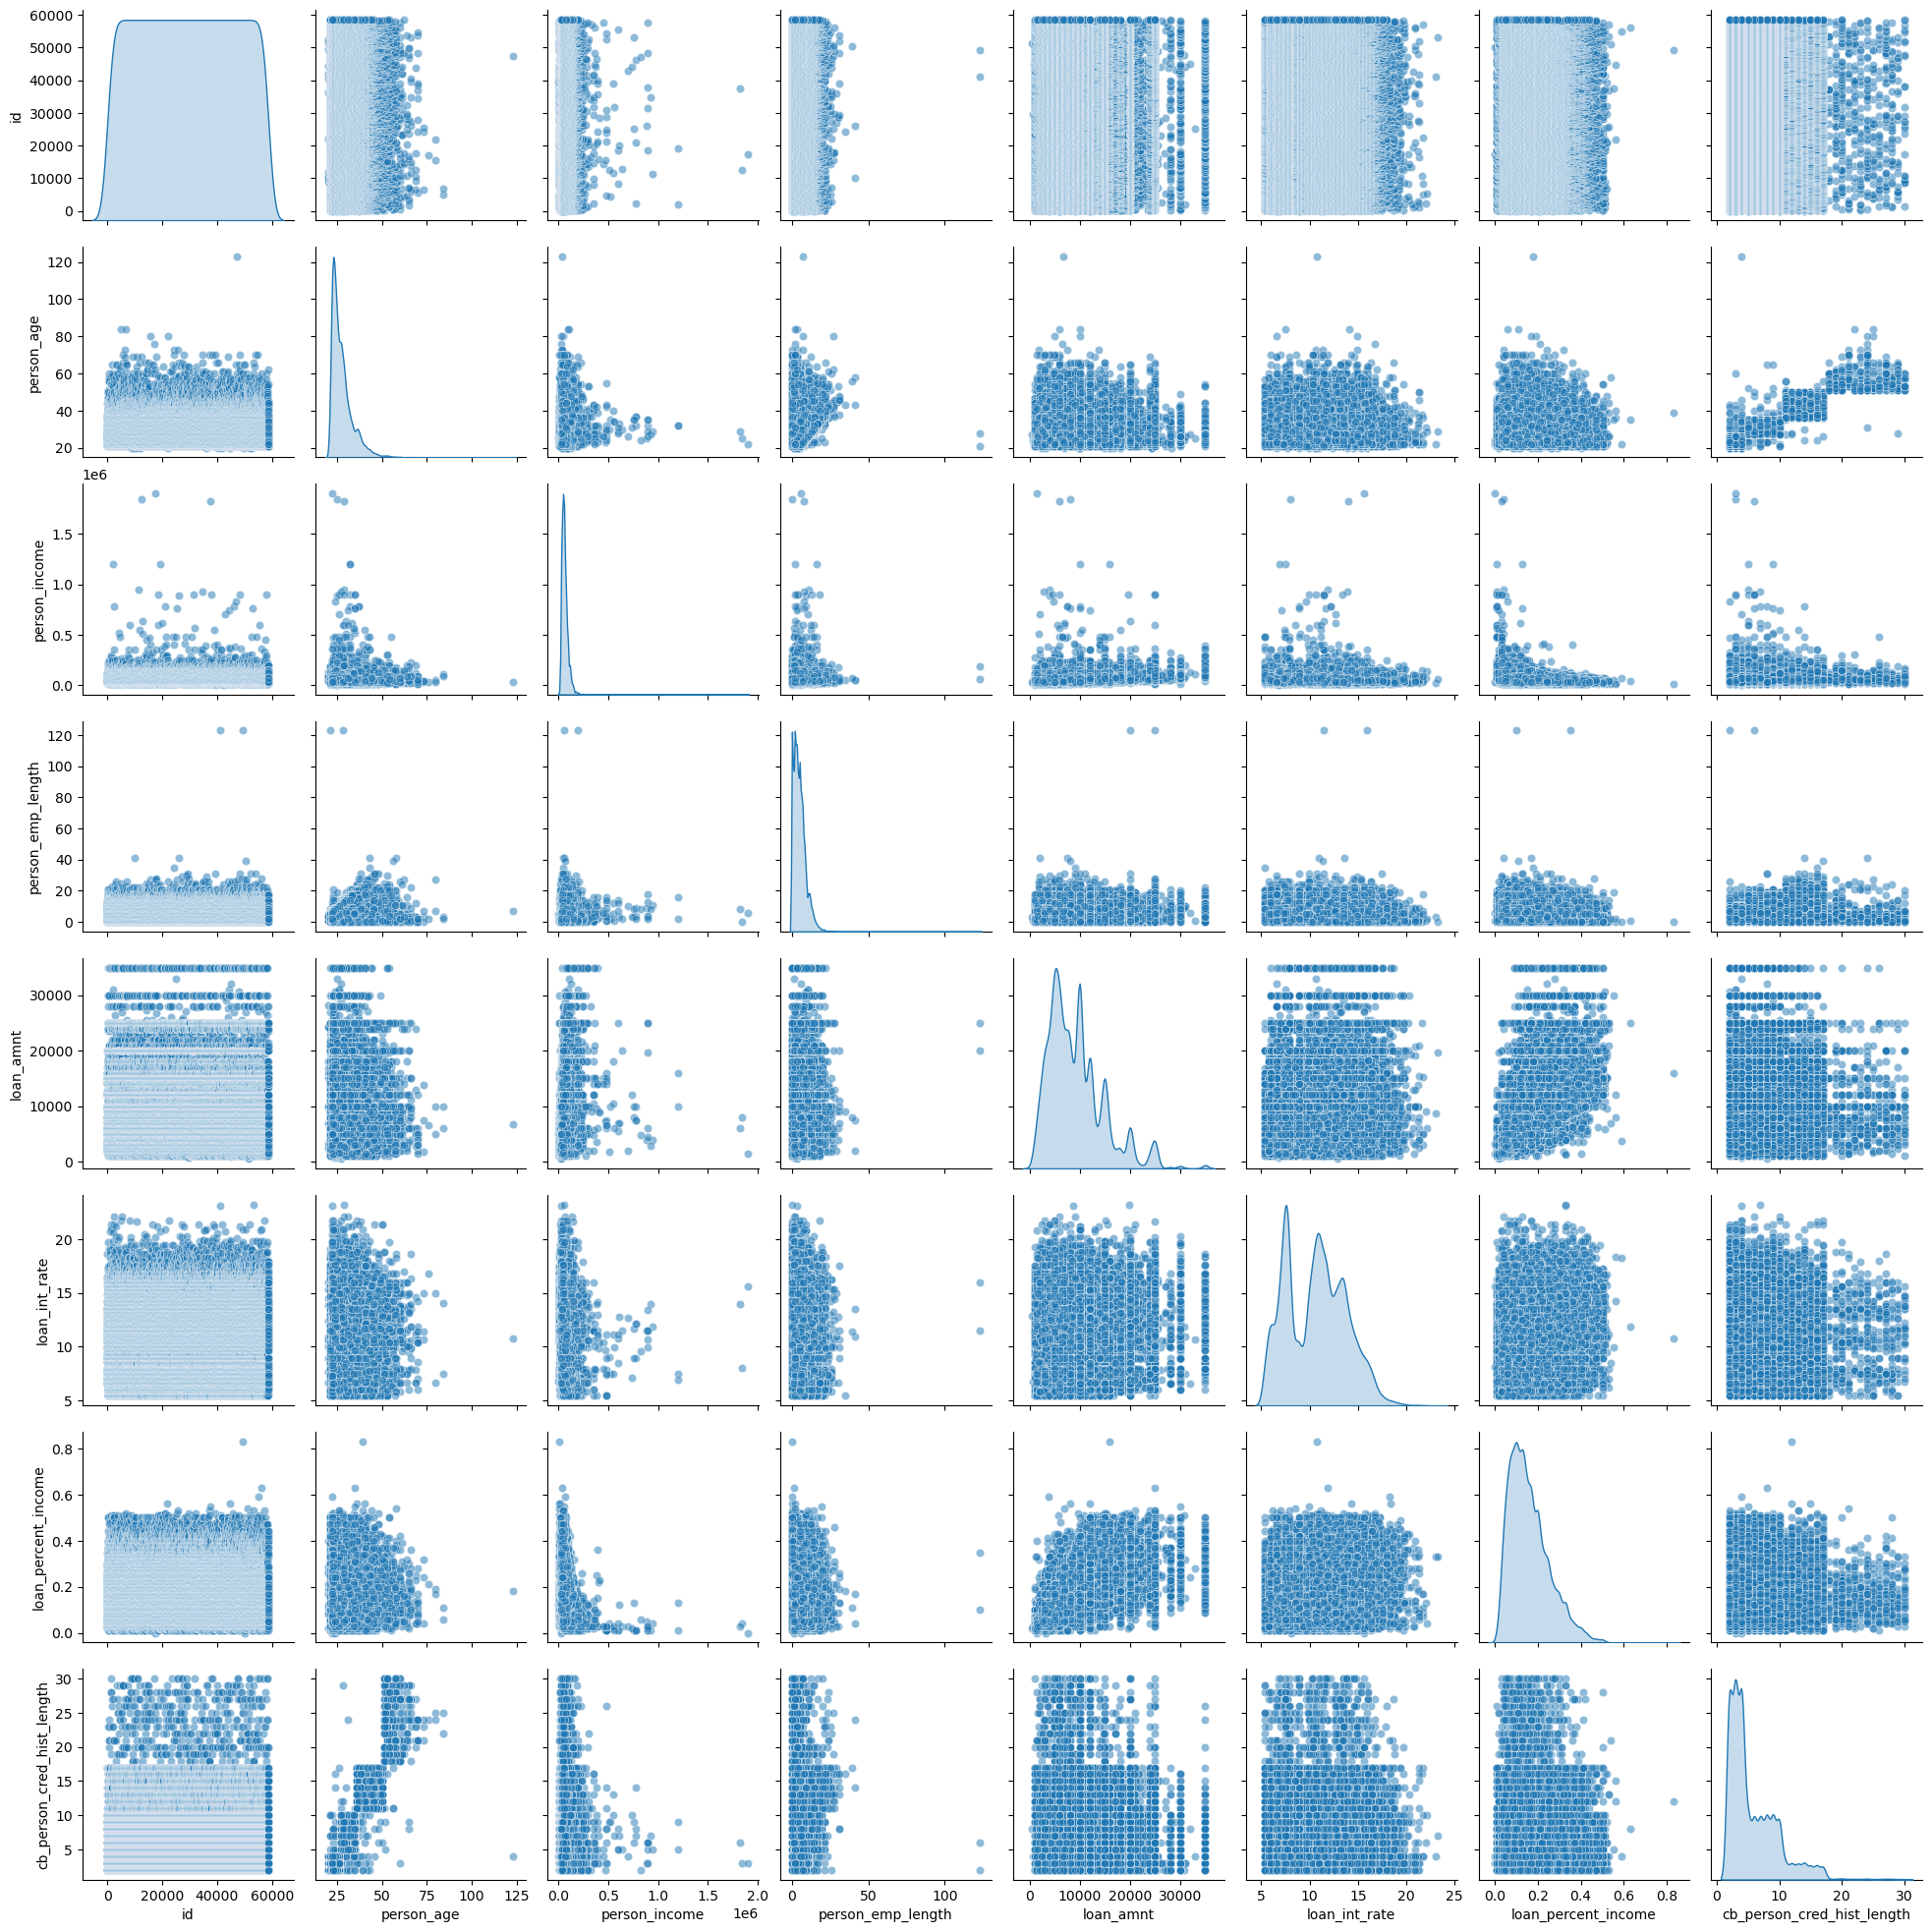

In [4]:
import seaborn as sns

# 繪製散點圖矩陣
features = [col for col in df.columns if col != target]
sns.pairplot(df[features], diag_kind='kde', plot_kws={'alpha': 0.5})
plt.show()

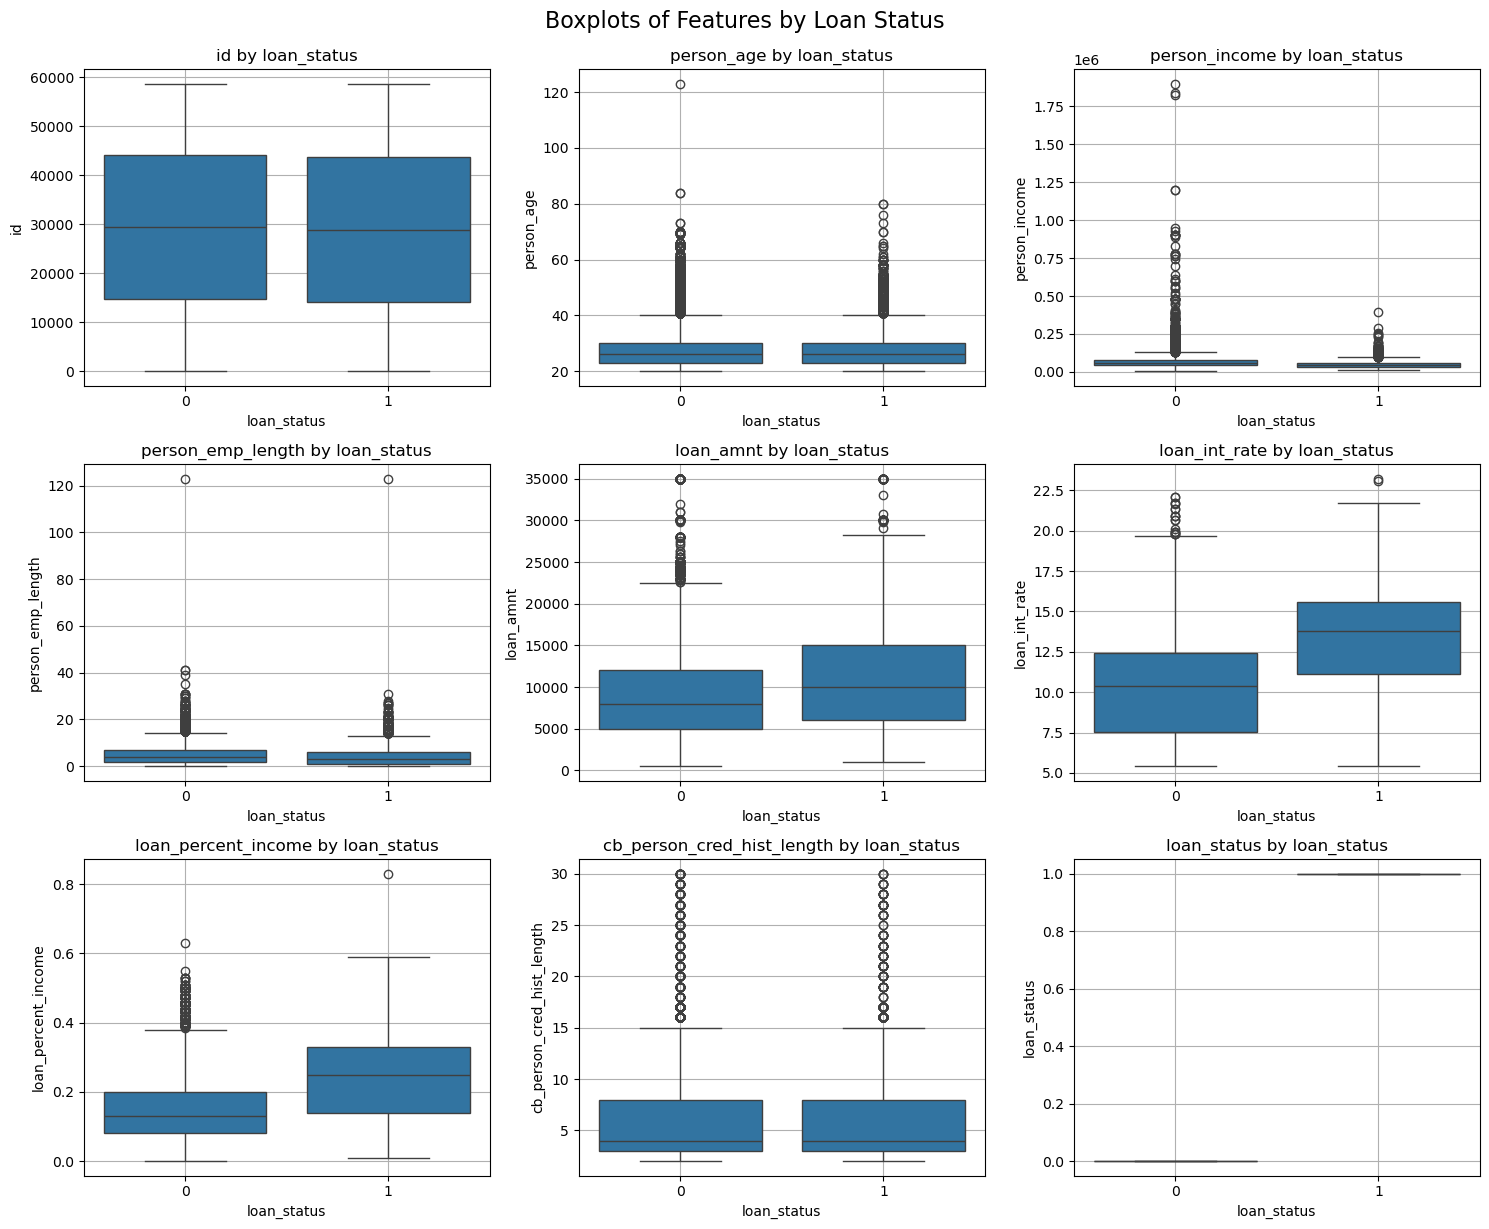

In [5]:
# 選取數值型欄位
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
numeric_features = [col for col in numeric_columns if col != 'target']

n = len(numeric_features)
cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()  # 展平成一維陣列，方便迴圈操作

for i, feature in enumerate(numeric_features):
    sns.boxplot(x='loan_status', y=feature, data=df, ax=axes[i])
    axes[i].set_title(f'{feature} by loan_status')
    axes[i].grid(True)

# 移除多餘的空白子圖
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Boxplots of Features by Loan Status', fontsize=16, y=1.02)
plt.show()

Data Preprocessing

In [6]:
# drop id
df.drop(columns=['id'], inplace=True)
te_df.drop(columns=['id'], inplace=True)

# 檢查缺失值
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0] if missing_values.any() else "No missing values found.")

# 標準化
from sklearn.preprocessing import StandardScaler

numeric_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 
					'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])
te_df[numeric_features] = scaler.transform(te_df[numeric_features])

Missing values in each column:
No missing values found.


In [7]:
# 列出待處理的類別型變數
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

for col in categorical_columns:
    unique_values = df[col].unique()
    print(f"待處理欄位: {col}, 類別值: {unique_values}")

待處理欄位: person_home_ownership, 類別值: ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
待處理欄位: loan_intent, 類別值: ['EDUCATION' 'MEDICAL' 'PERSONAL' 'VENTURE' 'DEBTCONSOLIDATION'
 'HOMEIMPROVEMENT']
待處理欄位: loan_grade, 類別值: ['B' 'C' 'A' 'D' 'E' 'F' 'G']
待處理欄位: cb_person_default_on_file, 類別值: ['N' 'Y']


In [8]:
# 處理類別型資料
one_hot_cols = ['person_home_ownership', 'loan_intent']
ordinal_cols = {'loan_grade': ['A', 'B', 'C', 'D', 'E', 'F', 'G']}  # 具有順序
binary_cols = ['cb_person_default_on_file']  # 類別僅有N/Y

# One-Hot Encoding
for col in one_hot_cols:
    print(f"One-Hot Encoding: {col}")
    dummies = pd.get_dummies(df[col], prefix=col)
    df = pd.concat([df, dummies], axis=1)
    df.drop(columns=[col], inplace=True)
    # 同步處理 te_df
    tr_dummies = pd.get_dummies(te_df[col], prefix=col)
    te_df = pd.concat([te_df, tr_dummies], axis=1)
    te_df.drop(columns=[col], inplace=True)
    

# Ordinal Encoding
for col, order in ordinal_cols.items():
    print(f"Ordinal Encoding: {col}")
    df[col] = df[col].astype(pd.CategoricalDtype(categories=order, ordered=True)).cat.codes
    te_df[col] = te_df[col].astype(pd.CategoricalDtype(categories=order, ordered=True)).cat.codes

# Label Encoding
for col in binary_cols:
    print(f"Label Encoding (binary): {col}")
    df[col] = df[col].map({'Y': 1, 'N': 0})
    te_df[col] = te_df[col].map({'Y': 1, 'N': 0})

One-Hot Encoding: person_home_ownership
One-Hot Encoding: loan_intent
Ordinal Encoding: loan_grade
Label Encoding (binary): cb_person_default_on_file


In [11]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# 分離特徵與目標變數
X = df.drop(columns=['loan_status'])
y = df['loan_status']

# 將資料分為訓練集與測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# smote, over sampling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 檢查過採樣後的類別分佈
print("原始訓練集類別分佈：")
print(y_train.value_counts())
print("\n過採樣後的訓練集類別分佈：")
print(y_train_resampled.value_counts())

原始訓練集類別分佈：
loan_status
0    40236
1     6680
Name: count, dtype: int64

過採樣後的訓練集類別分佈：
loan_status
0    40236
1    40236
Name: count, dtype: int64


Model Prediction

In [12]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

# 初始化 Random Forest 模型
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 訓練模型
rf_model.fit(X_train_resampled, y_train_resampled)

# 預測測試集
y_pred = rf_model.predict(X_test)

# 預測機率（用於計算 ROC AUC）
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# 評估模型
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba))

Confusion Matrix:
[[9875  184]
 [ 451 1219]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     10059
           1       0.87      0.73      0.79      1670

    accuracy                           0.95     11729
   macro avg       0.91      0.86      0.88     11729
weighted avg       0.94      0.95      0.94     11729


ROC AUC Score:
0.9318321305495183


In [13]:
# XGBoost
from xgboost import XGBClassifier

xgb_model = XGBClassifier(random_state=42, eval_metric='auc')

# 訓練模型
xgb_model.fit(X_train_resampled, y_train_resampled)

# 預測測試集
y_pred = xgb_model.predict(X_test)

# 評估模型
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 計算 ROC AUC Score
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba))

Confusion Matrix:
[[9916  143]
 [ 437 1233]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     10059
           1       0.90      0.74      0.81      1670

    accuracy                           0.95     11729
   macro avg       0.93      0.86      0.89     11729
weighted avg       0.95      0.95      0.95     11729


ROC AUC Score:
0.9529222497444718


In [15]:
import datetime

# 獲取當前時間戳
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")

# 使用訓練好的模型進行預測
test_pred_proba = xgb_model.predict_proba(te_df)[:, 1]  # 獲取正類別的預測機率

# 建立提交檔案
submission = pd.DataFrame({
    'id': pd.read_csv('test.csv')['id'],  # 從原始 test.csv 中讀取 'id' 欄位
    'loan_status': test_pred_proba  # 預測的機率
})

# 動態生成檔案名稱
submission_filename = f"submission_{timestamp}.csv"

# 輸出成 CSV 檔案
submission.to_csv(submission_filename, index=False)

print(f"Submission file saved as '{submission_filename}'")

Submission file saved as 'submission_20250506_2241.csv'
